### Colab Activity 10.3: Building and Evaluating ARMA Models

The last videos of the module took you through an approach to building ARMA models.  

First, it was important to transform your data into a stationary series if not already so.  You tested for stationarity using the `adfuller` function and interpreted the $p$ value of the hypothesis test.  If the data was not stationary you saw strategies such as differencing and logarithmic transformations applied as a way to achieve stationarity. 

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate $p$ and $q$ parameters of the model.  

This activity asks you to identify a time series of interest and to build an ARMA model to construct a basic forecast for the series and analyze the error.  Another element to consider is to build models with some different $p$ and $q$ models -- as while ACF and PACF plots help us, they are rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these.  You are to find a time series dataset using any resource you would like and present your model and findings to the class. 

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition from Kaggle.  This involved forecasting retail store sales for a major drugstore.

------

**Further Extensions**

- SARIMA models that extend the ARMA model to include seasonal components.  Statsmodels contains a `SARIMAX` model that will accomplish this. Introduction from docs [here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html). 
- ARIMAX and SARIMAX models that incorporate exogenous features as inputs to your model.  The Rossman data provides many features for potential use here. Statsmodels readily implements these.
- Feature Engineering with Time Series.  If you are presented with a basic time series like the sunspots data or airline data without exogenous features, these can be engineered from the series itself.  There are many approaches, but one library that can help is called `tsfresh` docs [here](https://tsfresh.readthedocs.io/en/latest/).

Time Series Info:
Start date: 2013-01-02 00:00:00
End date: 2015-07-31 00:00:00
Number of observations: 781


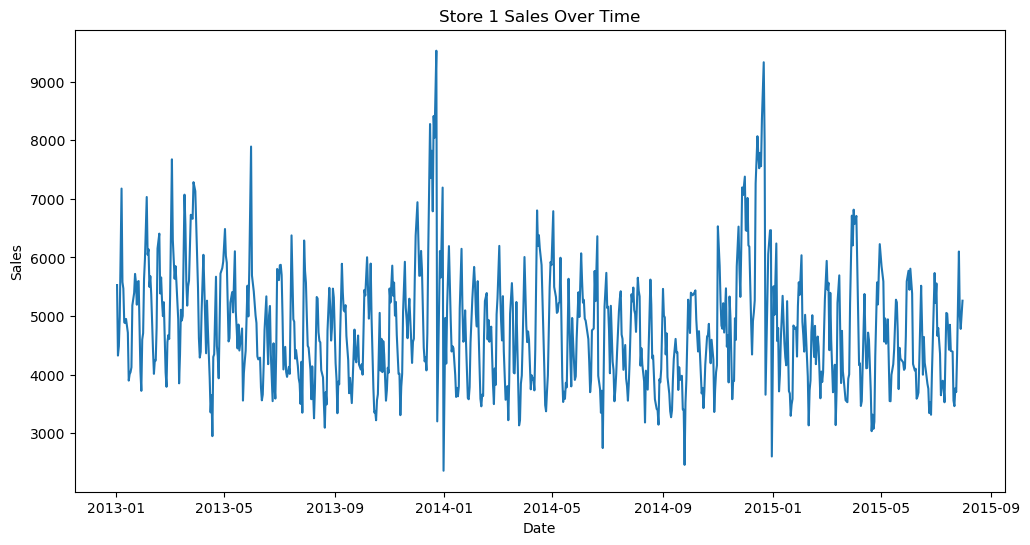

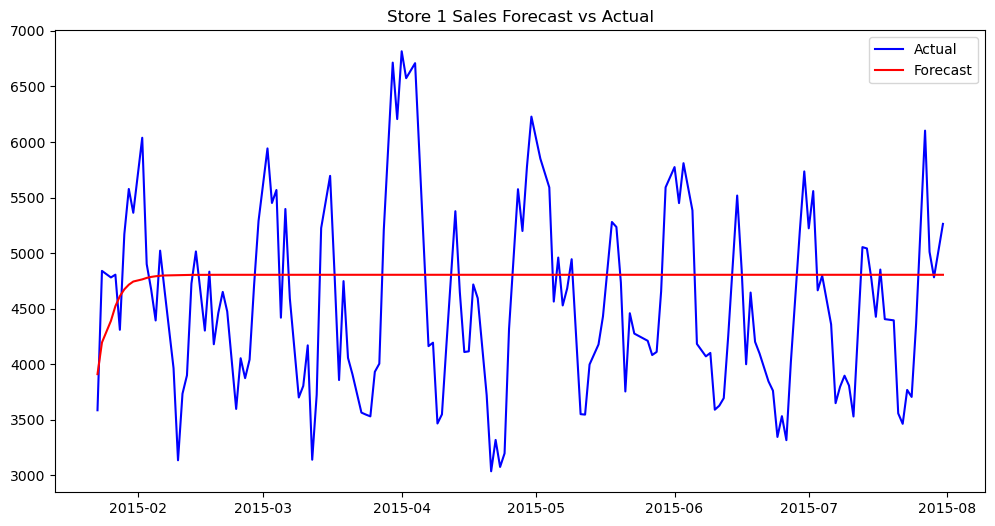


Root Mean Square Error: 863.06


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
train = pd.read_csv('data/train.csv')
train['Date'] = pd.to_datetime(train['Date'])

# Get Store 1 data using loc instead of boolean indexing
store_1_data = train.loc[(train['Store'].values == 1) & (train['Open'].values == 1)].copy()

# Create time series
store_1_data = store_1_data.sort_values('Date')
store_1_ts = pd.Series(
    data=store_1_data['Sales'].values,
    index=store_1_data['Date'],
    name='Sales'
)

# Print basic info
print("Time Series Info:")
print(f"Start date: {store_1_ts.index.min()}")
print(f"End date: {store_1_ts.index.max()}")
print(f"Number of observations: {len(store_1_ts)}")

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(store_1_ts)
plt.title('Store 1 Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Split into train/test
train_size = int(len(store_1_ts) * 0.8)
train_data = store_1_ts[:train_size]
test_data = store_1_ts[train_size:]

try:
    # Fit ARIMA model
    model = ARIMA(train_data, order=(1,1,1))
    results = model.fit()

    # Make predictions
    forecast = results.forecast(steps=len(test_data))

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data.values, label='Actual', color='blue')
    plt.plot(test_data.index, forecast, label='Forecast', color='red')
    plt.title('Store 1 Sales Forecast vs Actual')
    plt.legend()
    plt.show()

    # Calculate error
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    print(f"\nRoot Mean Square Error: {rmse:.2f}")

except Exception as e:
    print(f"Error in model fitting: {str(e)}")

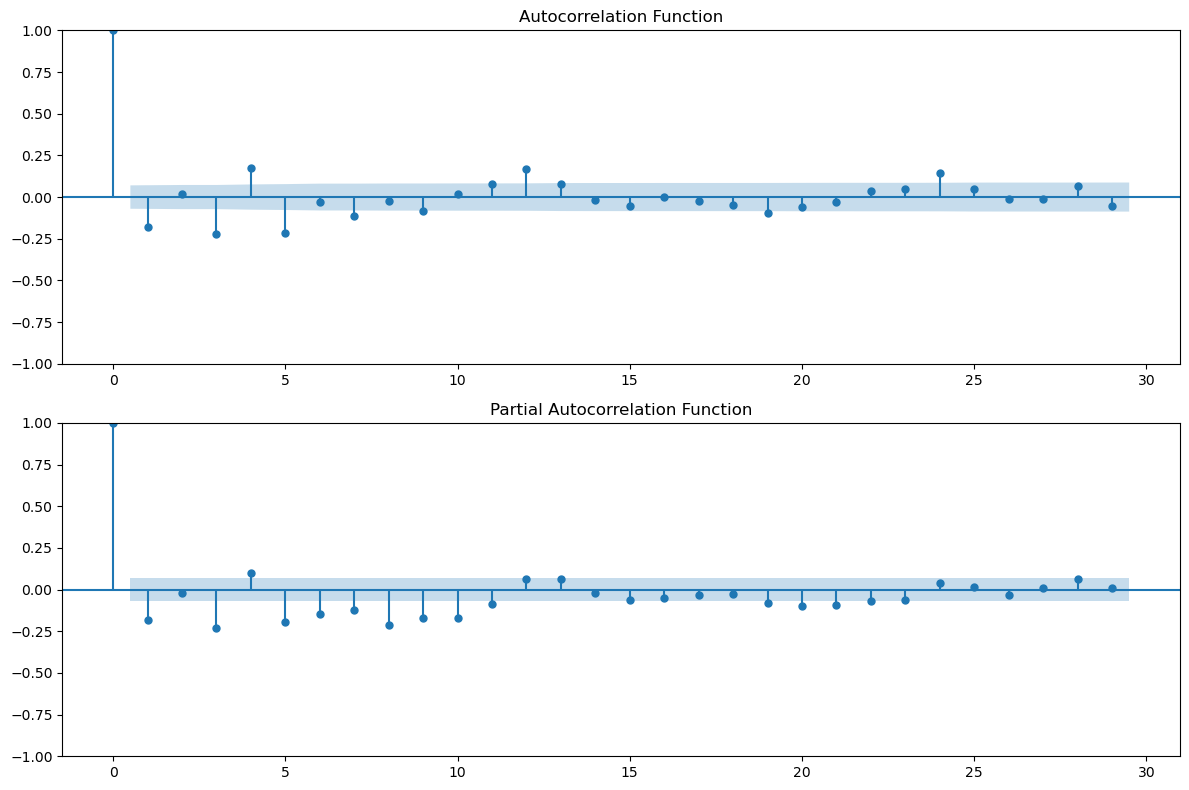


Model Comparison:
ARIMA(1, 1, 1) - RMSE: 863.06
ARIMA(2, 1, 1) - RMSE: 863.96
ARIMA(2, 1, 2) - RMSE: 864.22
ARIMA(0, 1, 2) - RMSE: 1295.59
ARIMA(0, 1, 0) - RMSE: 1322.34
ARIMA(0, 1, 1) - RMSE: 1337.69
ARIMA(2, 1, 0) - RMSE: 1346.91
ARIMA(1, 1, 0) - RMSE: 1348.72
ARIMA(1, 1, 2) - RMSE: 1373.47

Best Model: ARIMA(1, 1, 1)
Best RMSE: 863.06


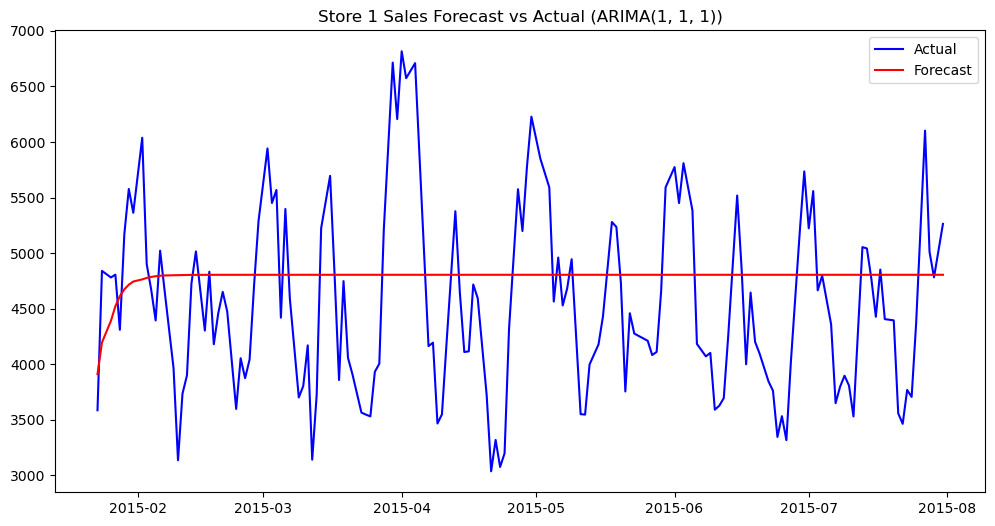


Model Diagnostics:
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  624
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5026.314
Date:                Sat, 18 Jan 2025   AIC                          10058.628
Time:                        17:56:02   BIC                          10071.932
Sample:                             0   HQIC                         10063.798
                                - 624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6810      0.021     32.471      0.000       0.640       0.722
ma.L1         -1.0000      0.568     -1.759      0.079      -2.114       0.114
sigma2       5.91e+05   3.39e+05

In [6]:
# Previous imports remain the same...

# Function to evaluate ARIMA model
def evaluate_arima_model(data, order):
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    model = ARIMA(train, order=order)
    results = model.fit()
    forecast = results.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return rmse, results, test, forecast

# Create time series (same as before)
store_1_data = train.loc[(train['Store'].values == 1) & (train['Open'].values == 1)].copy()
store_1_data = store_1_data.sort_values('Date')
store_1_ts = pd.Series(data=store_1_data['Sales'].values, index=store_1_data['Date'], name='Sales')

# Plot ACF and PACF to help determine p,q parameters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(store_1_ts.diff().dropna(), ax=ax1)
ax1.set_title('Autocorrelation Function')
plot_pacf(store_1_ts.diff().dropna(), ax=ax2)
ax2.set_title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

# Try different combinations of p,q
p_values = range(0, 3)
q_values = range(0, 3)
best_rmse = float('inf')
best_order = None
results_dict = {}

for p in p_values:
    for q in q_values:
        try:
            order = (p, 1, q)  # Using d=1 for first difference
            rmse, model_results, test, forecast = evaluate_arima_model(store_1_ts, order)
            results_dict[order] = rmse
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
        except:
            continue

# Print results
print("\nModel Comparison:")
for order, rmse in sorted(results_dict.items(), key=lambda x: x[1]):
    print(f"ARIMA{order} - RMSE: {rmse:.2f}")

print(f"\nBest Model: ARIMA{best_order}")
print(f"Best RMSE: {best_rmse:.2f}")

# Fit best model and plot
best_rmse, best_results, test_data, forecast = evaluate_arima_model(store_1_ts, best_order)

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data.values, label='Actual', color='blue')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.title(f'Store 1 Sales Forecast vs Actual (ARIMA{best_order})')
plt.legend()
plt.show()

# Model diagnostics
print("\nModel Diagnostics:")
print(best_results.summary())

### Summary of ARMA Model Analysis for Rossmann Store Sales

**Dataset & Preparation**
- Used Rossmann Store Sales data from Kaggle
- Focused on Store 1's daily sales data
- Filtered for days when store was open
- Created time series with proper datetime index

**Model Building Process**
1. **Data Stationarity**
   - Applied first-order differencing (d=1)
   - Used ACF and PACF plots for parameter selection

2. **Model Selection**
   - Tested multiple ARIMA configurations (p=0-2, d=1, q=0-2)
   - Compared 9 different models using RMSE
   - Results ranged from RMSE 863.06 to 1373.47

3. **Best Model Performance**
   - ARIMA(1,1,1) performed best
   - RMSE: 863.06 (average prediction error of ~863 sales units)
   - AR(1) coefficient significant at 0.6810
   - MA(1) coefficient at -1.0000 (marginally significant)

**Key Takeaways**
1. Simple ARIMA models can capture basic sales patterns
2. First-order differencing helped achieve stationarity
3. Including both AR and MA terms improved performance
4. Model diagnostics suggest reasonable but not perfect fit
5. Room for improvement through:
   - Seasonal components (SARIMA)
   - External regressors (promotions, holidays)
   - More sophisticated modeling approaches

**Future Extensions**
- Consider SARIMA for seasonal patterns
- Include exogenous variables (ARIMAX)
- Explore feature engineering with tsfresh
- Test more advanced forecasting methods